In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import math
import sklearn.metrics as metrics
import statistics
import pandas as pd

from fields import IncParseField

In [3]:
def crop_chart(chart: np.array, begin: int, n_future: int = 10):
    """Crop the beginning and the end of a chart around a position."""
    # look at up n_future tokens into the future
    chart = chart[begin: begin + n_future, begin: begin + n_future]
    return np.expand_dims(chart, 0)

COLS = ['noun', 'verb 1', 'det', 'noun', 'verb 2', '...', '...', '...', '...', '...']
NNC_STIMULUS_COLS = ['This', 'is', 'the', 'N1', 'N2', ',']
NNC_BASELINE_COLS = ['This', 'is', 'the', 'N1', ',']
NNC_DIFF_COLS = ['This', 'is', 'the', 'noun1', 'noun2']

NNC_REFERENCE = ['first', 'prev']
NPS_REFERENCE = ['last', 'prev']
MVRR_REFERENCE = ['last', 'prev']

In [4]:
biaffine = './outputs/preprocessed_dep-biaffine-roberta-en.pkl'
diaparser_ewt = './outputs/preprocessed_en_ewt.electra-base.pkl'
diaparser_ptb = './outputs/preprocessed_en_ptb.electra-base.pkl'

with open(biaffine, 'rb') as f:
    biaffine_data = pickle.load(f)

with open(diaparser_ewt, 'rb') as f:
    diaparser_ewt_data = pickle.load(f)

with open(diaparser_ptb, 'rb') as f:
    diaparser_ptb_data = pickle.load(f)

biaffine_parse = [IncParseField(biaffine_data[idx]) for idx in range(len(biaffine_data))]
diaparser_ewt_parse = [IncParseField(diaparser_ewt_data[idx]) for idx in range(len(diaparser_ewt_data))]
diaparser_ptb_parse = [IncParseField(diaparser_ptb_data[idx]) for idx in range(len(diaparser_ptb_data))]

In [5]:
def mean_sap(parse, source, sent_type, reference):
    '''
    Compute the mean of Jensen-Shannon divergence w.r.t. reference for SAP benchmark.
    '''
    div_dict = {ref: [] for ref in reference}
    mean_dict = {}

    for field in parse:
        if field.source == source:
            field.compute_charts()
            field.detect_added_positions()
            mv_idx = field.amb_pos_ambig

            for ref in reference:
                chart = field.get_chart(sent_type, 'div_' + ref, remove_additions=True) if sent_type == 'baseline' else field.get_chart(sent_type, 'div_' + ref)
                cropped_chart = crop_chart(chart.numpy(), begin=mv_idx - 1)
                div_dict[ref].append(cropped_chart)
    
    
    for ref in reference:
        mean_dict[ref] = np.mean(np.abs(np.vstack(div_dict[ref])), axis=0)

    return mean_dict

def mean_sap_diff(parse, source, reference):
    '''
    Compute the mean absolute difference of Jensen-Shannon divergence between
    the stimulus and the baseline w.r.t. reference for SAP benchmark.
    '''
    div_dict = {ref: [] for ref in reference}
    mean_dict = {}

    for field in parse:
        if field.source == source:
            field.compute_charts()
            field.detect_added_positions()
            mv_idx = field.amb_pos_ambig

            for ref in reference:
                chart = field.get_diff_chart('div_' + ref)
                cropped_chart = crop_chart(chart.numpy(), begin=mv_idx - 1)
                div_dict[ref].append(cropped_chart)

    for ref in reference:
        mean_dict[ref] = np.mean(np.abs(np.vstack(div_dict[ref])), axis=0)

    return mean_dict
            

def mean_nnc(parse, sent_type, reference):
    '''
    Compute the mean of Jensen-Shannon divergence w.r.t. reference for NNC.
    '''
    div_dict = {ref: [] for ref in reference}
    mean_dict = {}

    for field in parse:
        if field.source == 'nnc':
            field.compute_charts()

            for ref in reference:
                div_dict[ref].append(field.get_chart(sent_type, 'div_' + ref).unsqueeze(0))

    for ref in reference:
        mean_dict[ref] = torch.mean(torch.abs(torch.cat(div_dict[ref], dim=0)), dim=0)

    return mean_dict

def mean_nnc_diff(parse, reference):
    '''
    Compute the mean absolute difference of Jensen-Shannon divergence between
    the stimulus and the baseline w.r.t. reference for NNC.
    '''
    div_dict = {ref: [] for ref in reference}
    mean_dict = {}

    for field in parse:
        if field.source == 'nnc':
            field.compute_charts()
            field.additions = [len(field.tokenized_stimulus)-1]

            for ref in reference:
                chart = field.get_diff_chart('div_' + ref)
                div_dict[ref].append(chart.unsqueeze(0))

    for ref in reference:
        mean_dict[ref] = torch.mean(torch.abs(torch.cat(div_dict[ref], dim=0)), dim=0)

    return mean_dict

In [6]:
def plot_sap(array, title, fname):
    '''
    Plot the Jensen-Shannon divergence for the stimulus and the baseline (NP/S and MVRR).
    '''
    annot_means = pd.DataFrame(array)
    annot = annot_means.apply(lambda col: [f'{v:.2f}'[-3:] for v in col], axis=0)

    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(array, xticklabels=COLS, yticklabels=COLS, 
                annot=annot, fmt='', square=True,
                annot_kws={"fontsize":12}, ax=ax, cbar=False, vmin=-0.05,vmax=math.log(2),cmap='BuPu', linewidths=0.1)
    ax.set_title(title, pad=-20, fontsize=16, loc='right')
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

def plot_sap_diff(array, title, fname):
    '''
    Plot the absolute difference of Jensen-Shannon divergence for the stimulus and the baseline (NP/S and MVRR).
    '''
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(array, xticklabels=COLS, yticklabels=COLS, 
                fmt='.2f', square=True,
                cbar=True, vmin=-0.05,vmax=0.35, cmap='BuPu', linewidths=0.1,
                cbar_kws={'shrink': 0.6, "pad":-0.15, "anchor": (0, 0.9)})
    plt.yticks(rotation=0)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.figure.axes[-1].tick_params(labelsize=12)
    plt.xlabel(title, labelpad=-18, fontsize=18, loc='right')
    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

def plot_nnc(array, sent_type, fname):
    '''
    Plot the Jensen-Shannon divergence for the stimulus and the baseline (NNC).
    '''
    fig, ax = plt.subplots(figsize=(4,4))
    if sent_type == 'stimulus':
        sns.heatmap(array, xticklabels=NNC_STIMULUS_COLS, yticklabels=NNC_STIMULUS_COLS, 
                    annot=True, fmt='.3f', square=True,
                    annot_kws={"fontsize":11}, ax=ax, cbar=False, vmin=-0.05,vmax=math.log(2), cmap='BuPu', linewidths=0.1)
        ax.set_title('Stimulus', pad=-20, fontsize=16, loc='right')
    else:
        sns.heatmap(array, xticklabels=NNC_BASELINE_COLS, yticklabels=NNC_BASELINE_COLS, 
                    annot=True, fmt='.3f', square=True,
                    annot_kws={"fontsize":12}, ax=ax, cbar=False, vmin=-0.05,vmax=math.log(2), cmap='BuPu', linewidths=0.1)
        ax.set_title('Baseline', pad=-20, fontsize=16, loc='right')
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    plt.tight_layout() 
    plt.savefig(fname, bbox_inches='tight')
    plt.show()


def plot_nnc_diff(array, fname):
    '''
    Plot the absolute difference of Jensen-Shannon divergence for the stimulus and the baseline (NNC).
    '''
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(array, xticklabels=NNC_DIFF_COLS, yticklabels=NNC_DIFF_COLS, 
                fmt='.2f', square=True,
                cbar=True, vmin=-0.05, vmax=math.log(2), cmap='BuPu', linewidths=0.1,
                cbar_kws={'shrink': 0.6, "pad":0.085, "anchor": (0, 0.5)})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.figure.axes[-1].tick_params(labelsize=12)
    plt.xlabel('NNC' , labelpad=-18, fontsize=18, x=1.2, y=1.5)
    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight')
    plt.show()

## NP/S

## Biaffine Parser (RoBERTa)

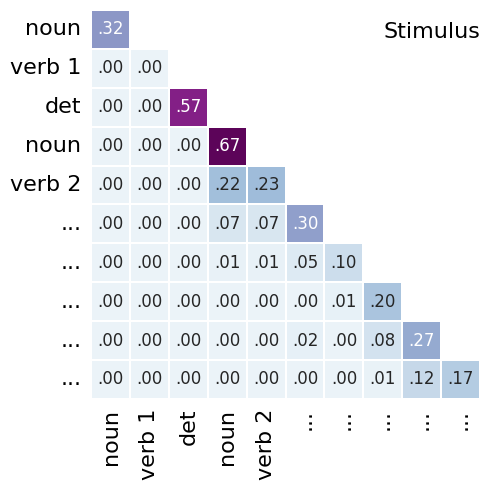

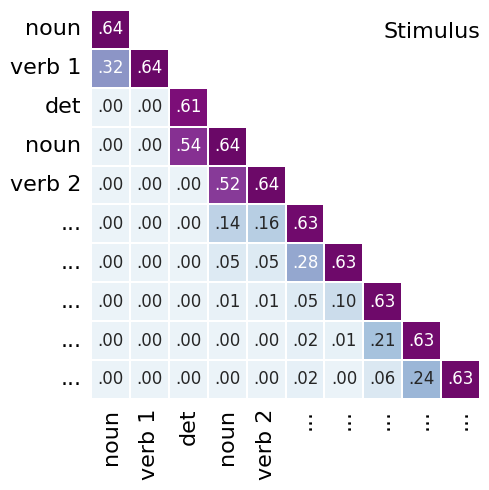

In [7]:
# Stimulus
nps_stimulus_dict = mean_sap(biaffine_parse, 'classic-nps', 'stimulus', NPS_REFERENCE)
plot_sap(nps_stimulus_dict['last'], 'Stimulus', './figures/nps/nps_roberta_last_stimulus.pdf')
plot_sap(nps_stimulus_dict['prev'], 'Stimulus', './figures/nps/nps_roberta_prev_stimulus.pdf')

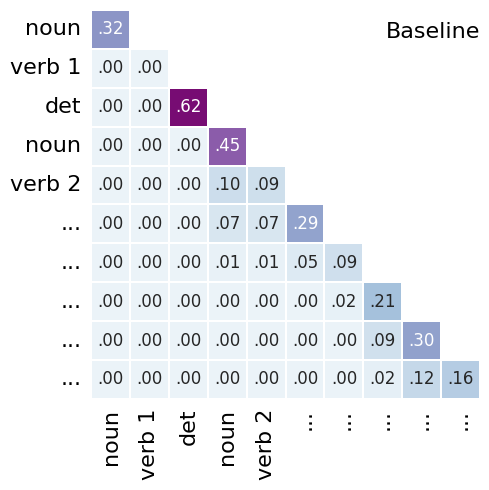

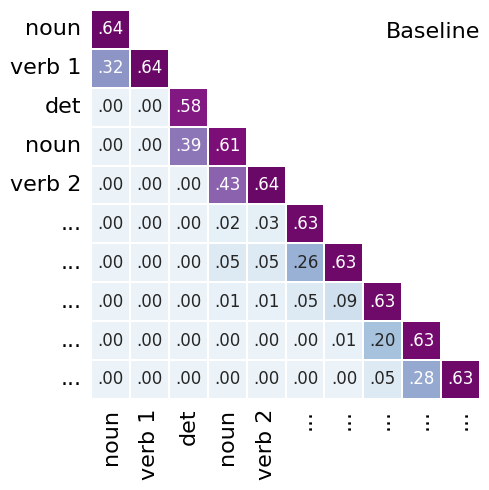

In [8]:
# Baseline
nps_baseline_dict = mean_sap(biaffine_parse, 'classic-nps', 'baseline', NPS_REFERENCE)
plot_sap(nps_baseline_dict['last'], 'Baseline', './figures/nps/nps_roberta_last_baseline.pdf')
plot_sap(nps_baseline_dict['prev'], 'Baseline', './figures/nps/nps_roberta_prev_baseline.pdf')

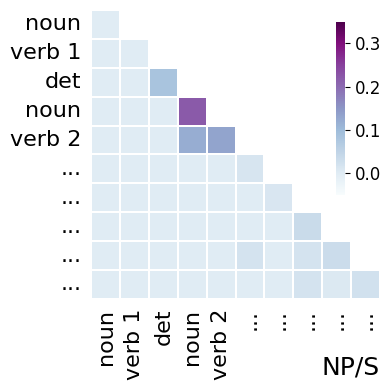

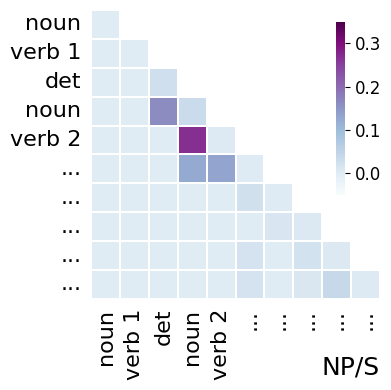

In [9]:
# Difference
nps_diff_dict = mean_sap_diff(biaffine_parse, 'classic-nps', NPS_REFERENCE)
plot_sap_diff(nps_diff_dict['last'], 'NP/S', './figures/nps/nps_roberta_last_diff.pdf')
plot_sap_diff(nps_diff_dict['prev'], 'NP/S', './figures/nps/nps_roberta_prev_diff.pdf')

## DiaParser (ELECTRA-EWT)

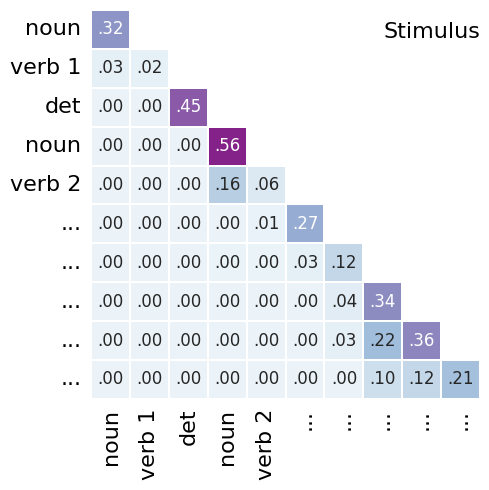

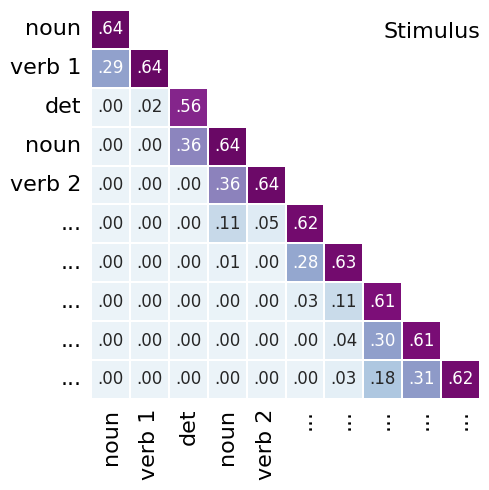

In [10]:
# Stimulus
nps_stimulus_dict = mean_sap(diaparser_ewt_parse, 'classic-nps', 'stimulus', NPS_REFERENCE)
plot_sap(nps_stimulus_dict['last'], 'Stimulus', './figures/nps/nps_electra_ewt_last_stimulus.pdf')
plot_sap(nps_stimulus_dict['prev'], 'Stimulus', './figures/nps/nps_electra_ewt_prev_stimulus.pdf')

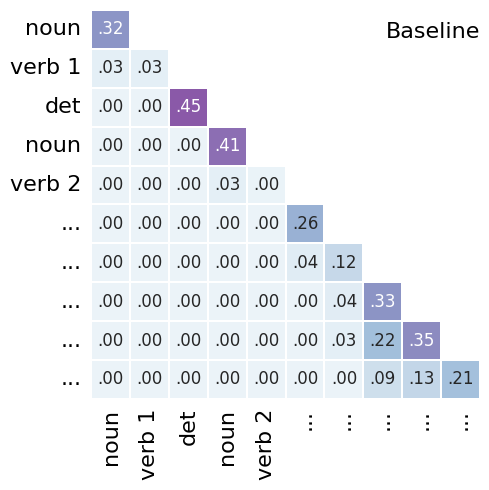

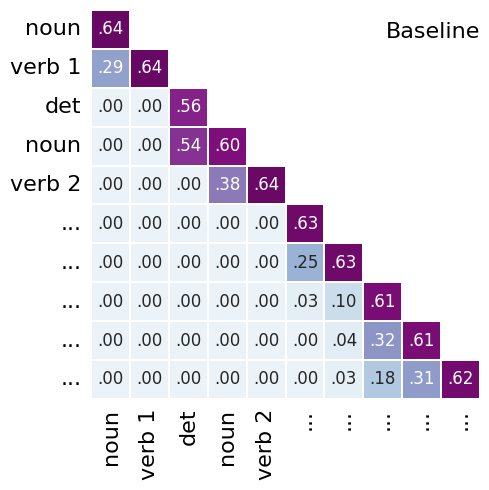

In [11]:
# Baseline
nps_baseline_dict = mean_sap(diaparser_ewt_parse, 'classic-nps', 'baseline', NPS_REFERENCE)
plot_sap(nps_baseline_dict['last'], 'Baseline', './figures/nps/nps_electra_ewt_last_baseline.pdf')
plot_sap(nps_baseline_dict['prev'], 'Baseline', './figures/nps/nps_electra_ewt_prev_baseline.pdf')

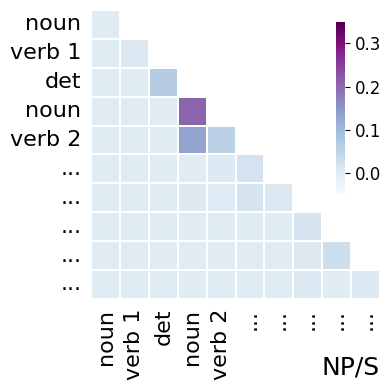

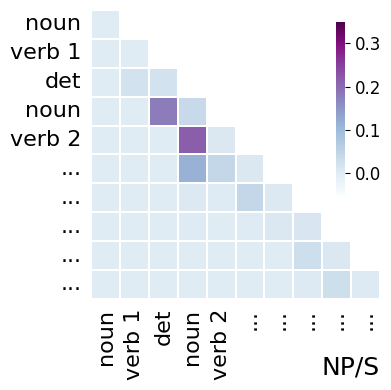

In [12]:
# Difference
nps_diff_dict = mean_sap_diff(diaparser_ewt_parse, 'classic-nps', NPS_REFERENCE)
plot_sap_diff(nps_diff_dict['last'], 'NP/S', './figures/nps/nps_electra_ewt_last_diff.pdf')
plot_sap_diff(nps_diff_dict['prev'], 'NP/S', './figures/nps/nps_electra_ewt_prev_diff.pdf')

## DiaParser (ELECTRA-PTB)

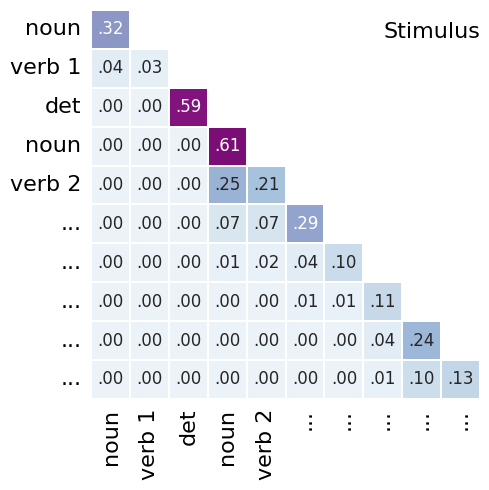

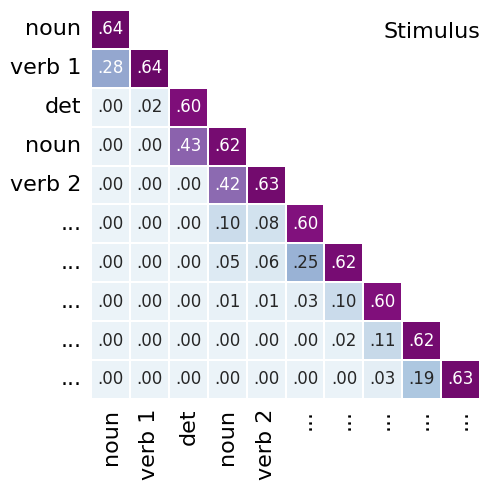

In [13]:
# Stimulus
nps_stimulus_dict = mean_sap(diaparser_ptb_parse, 'classic-nps', 'stimulus', NPS_REFERENCE)
plot_sap(nps_stimulus_dict['last'], 'Stimulus', './figures/nps/nps_electra_ptb_last_stimulus.pdf')
plot_sap(nps_stimulus_dict['prev'], 'Stimulus', './figures/nps/nps_electra_ptb_prev_stimulus.pdf')

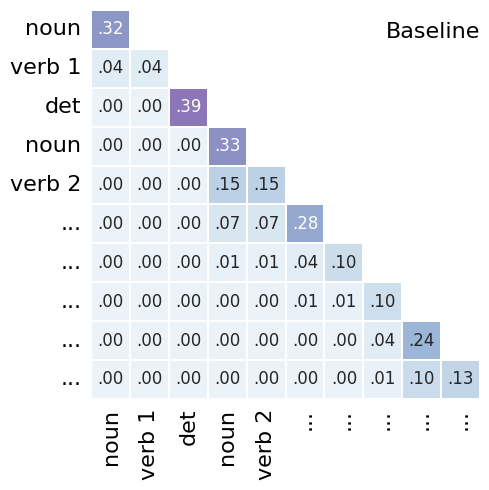

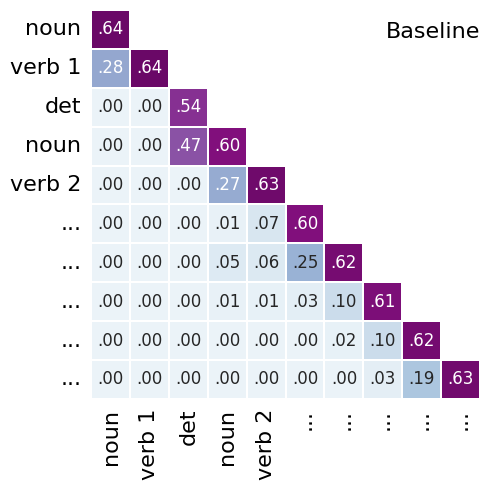

In [14]:
# Baseline
nps_baseline_dict = mean_sap(diaparser_ptb_parse, 'classic-nps', 'baseline', NPS_REFERENCE)
plot_sap(nps_baseline_dict['last'], 'Baseline', './figures/nps/nps_electra_ptb_last_baseline.pdf')
plot_sap(nps_baseline_dict['prev'], 'Baseline', './figures/nps/nps_electra_ptb_prev_baseline.pdf')

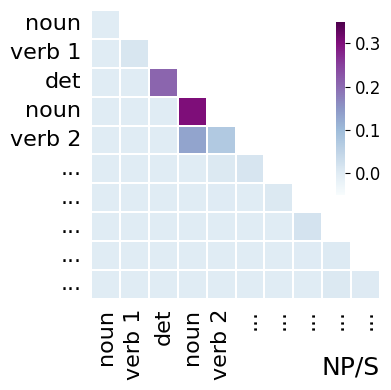

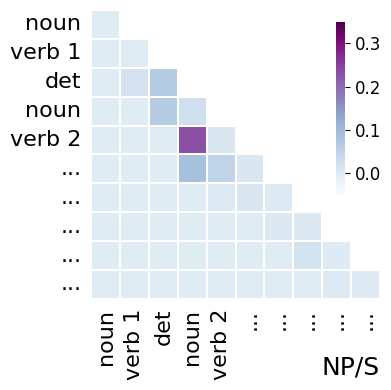

In [15]:
# Difference
nps_diff_dict = mean_sap_diff(diaparser_ptb_parse, 'classic-nps', NPS_REFERENCE)
plot_sap_diff(nps_diff_dict['last'], 'NP/S', './figures/nps/nps_electra_ptb_last_diff.pdf')
plot_sap_diff(nps_diff_dict['prev'], 'NP/S', './figures/nps/nps_electra_ptb_prev_diff.pdf')

## MVRR

## Biaffine Parser (RoBERTa)

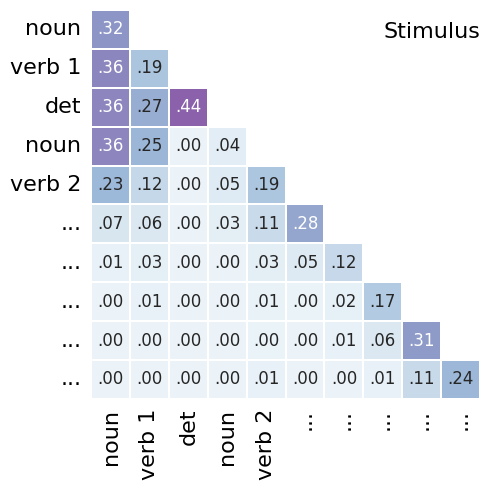

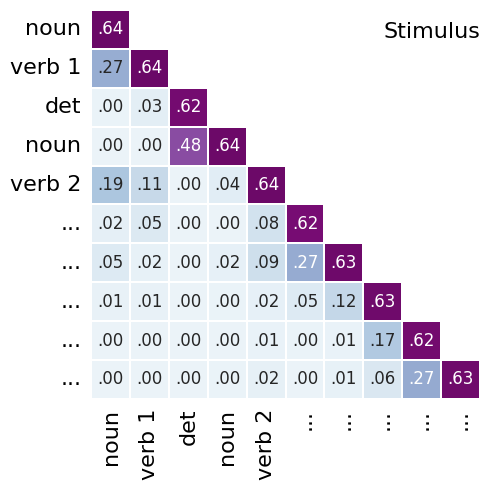

In [16]:
# Stimulus
mvrr_stimulus_dict = mean_sap(biaffine_parse, 'classic-mvrr', 'stimulus', MVRR_REFERENCE)
plot_sap(mvrr_stimulus_dict['last'], 'Stimulus', './figures/mvrr/mvrr_roberta_last_stimulus.pdf')
plot_sap(mvrr_stimulus_dict['prev'], 'Stimulus', './figures/mvrr/mvrr_roberta_prev_stimulus.pdf')

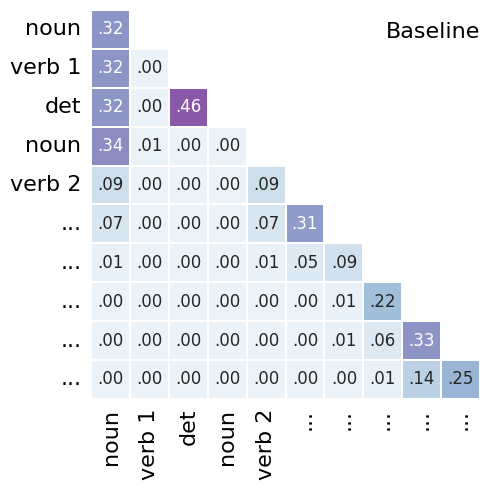

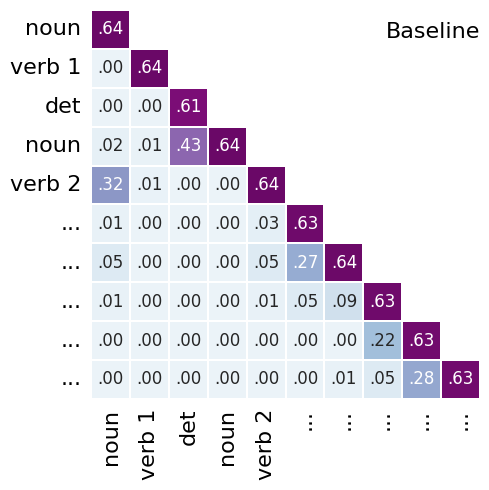

In [17]:
# Baseline
mvrr_baseline_dict = mean_sap(biaffine_parse, 'classic-mvrr', 'baseline', MVRR_REFERENCE)
plot_sap(mvrr_baseline_dict['last'], 'Baseline', './figures/mvrr/mvrr_roberta_last_baseline.pdf')
plot_sap(mvrr_baseline_dict['prev'], 'Baseline', './figures/mvrr/mvrr_roberta_prev_baseline.pdf')

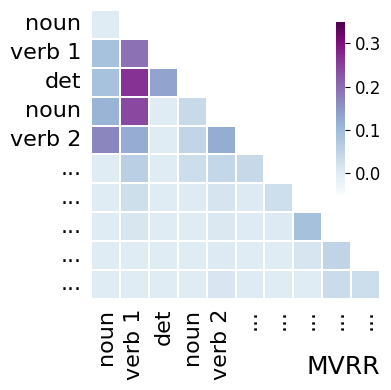

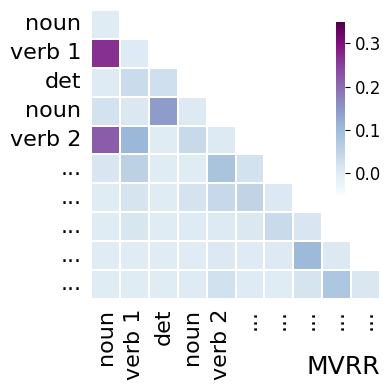

In [18]:
# Difference
mvrr_diff_dict = mean_sap_diff(biaffine_parse, 'classic-mvrr', MVRR_REFERENCE)
plot_sap_diff(mvrr_diff_dict['last'], 'MVRR', './figures/mvrr/mvrr_roberta_last_diff.pdf')
plot_sap_diff(mvrr_diff_dict['prev'], 'MVRR', './figures/mvrr/mvrr_roberta_prev_diff.pdf')

## DiaParser (ELECTRA-EWT)

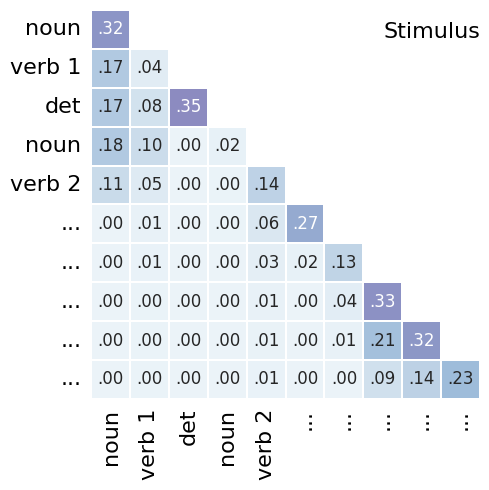

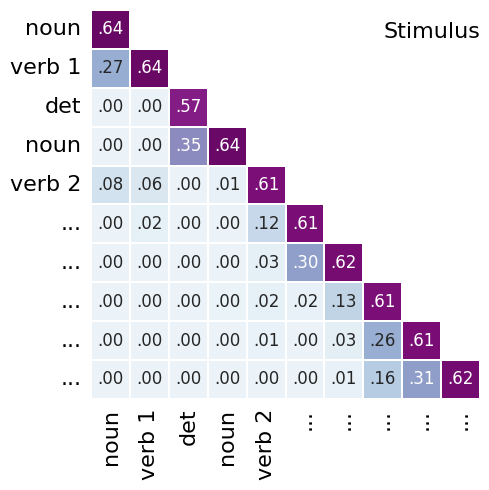

In [19]:
# Stimulus
mvrr_stimulus_dict = mean_sap(diaparser_ewt_parse, 'classic-mvrr', 'stimulus', MVRR_REFERENCE)
plot_sap(mvrr_stimulus_dict['last'], 'Stimulus', './figures/mvrr/mvrr_electra_ewt_last_stimulus.pdf')
plot_sap(mvrr_stimulus_dict['prev'], 'Stimulus', './figures/mvrr/mvrr_electra_ewt_prev_stimulus.pdf')

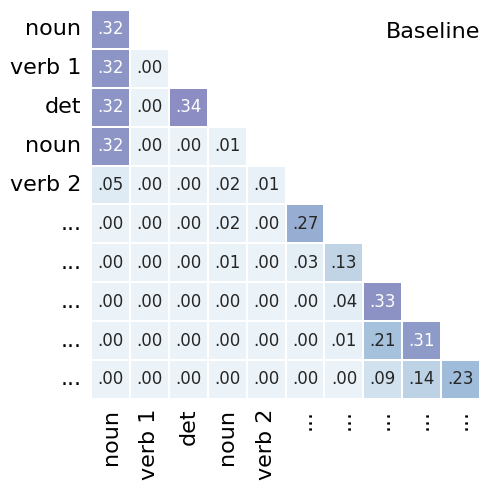

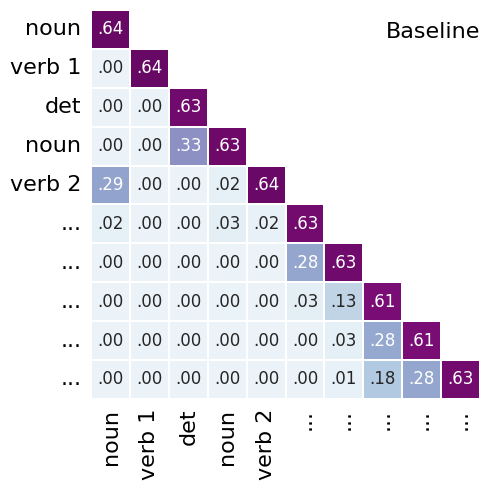

In [20]:
# Baseline
mvrr_baseline_dict = mean_sap(diaparser_ewt_parse, 'classic-mvrr', 'baseline', MVRR_REFERENCE)
plot_sap(mvrr_baseline_dict['last'], 'Baseline', './figures/mvrr/mvrr_electra_ewt_last_baseline.pdf')
plot_sap(mvrr_baseline_dict['prev'], 'Baseline', './figures/mvrr/mvrr_electra_ewt_prev_baseline.pdf')

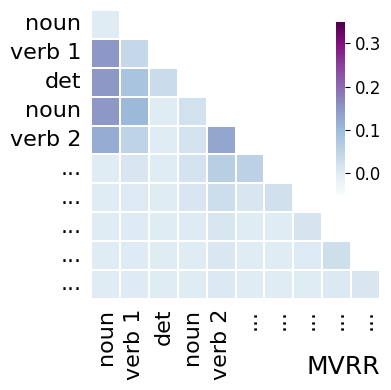

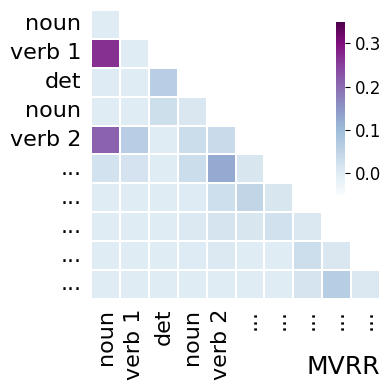

In [21]:
# Difference
mvrr_diff_dict = mean_sap_diff(diaparser_ewt_parse, 'classic-mvrr', MVRR_REFERENCE)
plot_sap_diff(mvrr_diff_dict['last'], 'MVRR', './figures/mvrr/mvrr_electra_ewt_last_diff.pdf')
plot_sap_diff(mvrr_diff_dict['prev'], 'MVRR', './figures/mvrr/mvrr_electra_ewt_prev_diff.pdf')

## DiaParser (ELECTRA-PTB)

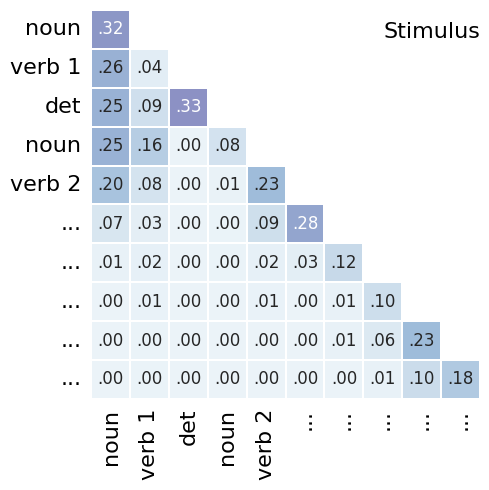

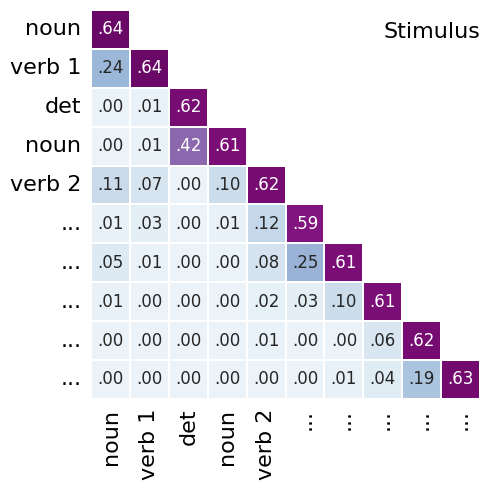

In [22]:
# Stimulus
mvrr_stimulus_dict = mean_sap(diaparser_ptb_parse, 'classic-mvrr', 'stimulus', MVRR_REFERENCE)
plot_sap(mvrr_stimulus_dict['last'], 'Stimulus', './figures/mvrr/mvrr_electra_ptb_last_stimulus.pdf')
plot_sap(mvrr_stimulus_dict['prev'], 'Stimulus', './figures/mvrr/mvrr_electra_ptb_prev_stimulus.pdf')

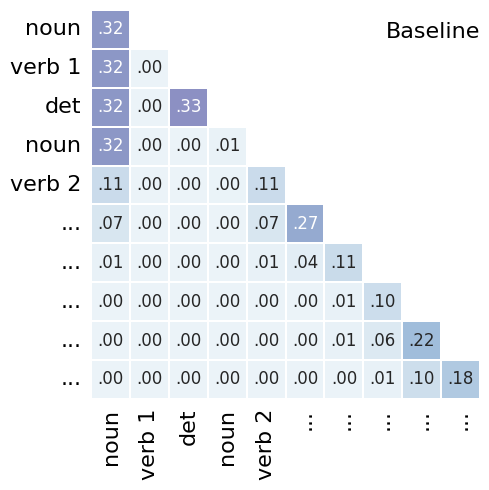

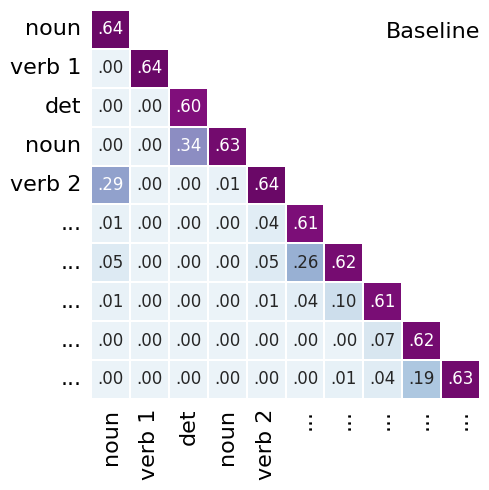

In [23]:
# Baseline
mvrr_baseline_dict = mean_sap(diaparser_ptb_parse, 'classic-mvrr', 'baseline', MVRR_REFERENCE)
plot_sap(mvrr_baseline_dict['last'], 'Baseline', './figures/mvrr/mvrr_electra_ptb_last_baseline.pdf')
plot_sap(mvrr_baseline_dict['prev'], 'Baseline', './figures/mvrr/mvrr_electra_ptb_prev_baseline.pdf')

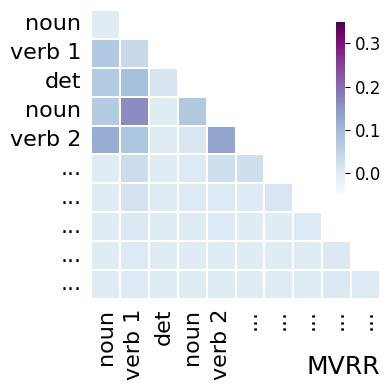

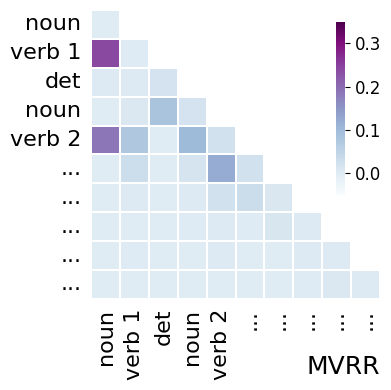

In [24]:
# Difference
mvrr_diff_dict = mean_sap_diff(diaparser_ptb_parse, 'classic-mvrr', MVRR_REFERENCE)
plot_sap_diff(mvrr_diff_dict['last'], 'MVRR', './figures/mvrr/mvrr_electra_ptb_last_diff.pdf')
plot_sap_diff(mvrr_diff_dict['prev'], 'MVRR', './figures/mvrr/mvrr_electra_ptb_prev_diff.pdf')

## NNC

## Biaffine Parser (RoBERTa)

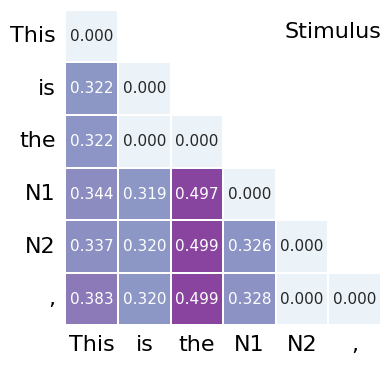

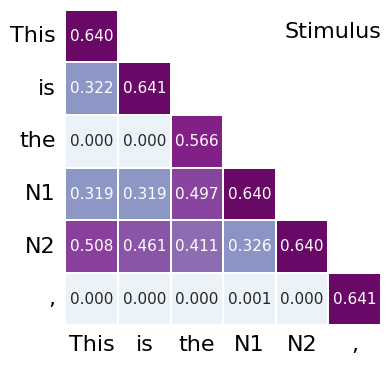

In [25]:
# Stimulus
nnc_stimulus_dict = mean_nnc(biaffine_parse, 'stimulus', NNC_REFERENCE)
plot_nnc(nnc_stimulus_dict['first'], 'stimulus', './figures/nnc/nnc_roberta_first_stimulus.pdf')
plot_nnc(nnc_stimulus_dict['prev'], 'stimulus', './figures/nnc/nnc_roberta_prev_stimulus.pdf')

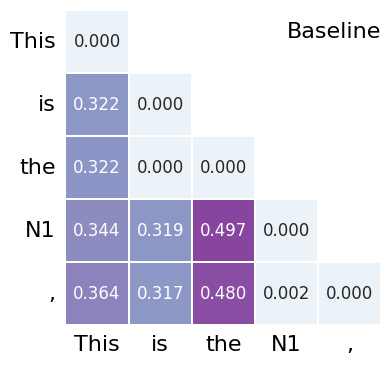

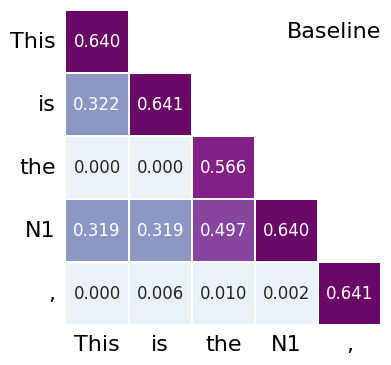

In [26]:
# Baseline
nnc_stimulus_dict = mean_nnc(biaffine_parse, 'baseline', NNC_REFERENCE)
plot_nnc(nnc_stimulus_dict['first'], 'baseline', './figures/nnc/nnc_roberta_first_baseline.pdf')
plot_nnc(nnc_stimulus_dict['prev'], 'baseline', './figures/nnc/nnc_roberta_prev_baseline.pdf')

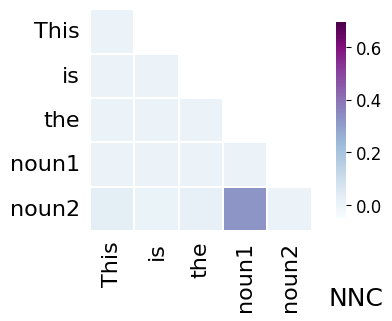

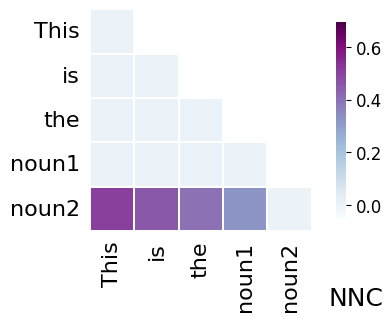

In [27]:
# Difference
nnc_diff_dict = mean_nnc_diff(biaffine_parse, NNC_REFERENCE)
plot_nnc_diff(nnc_diff_dict['first'], './figures/nnc/nnc_roberta_first_diff.pdf')
plot_nnc_diff(nnc_diff_dict['prev'], './figures/nnc/nnc_roberta_prev_diff.pdf')

## DiaParser (ELECTRA-EWT)

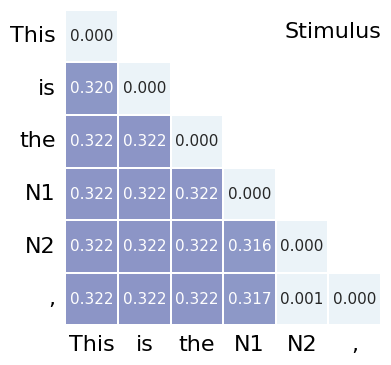

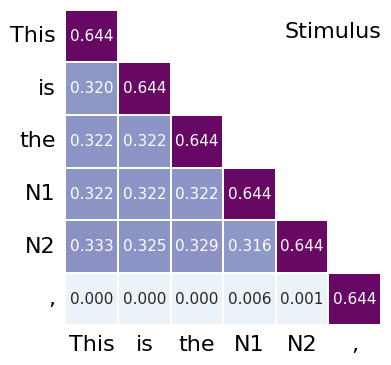

In [28]:
# Stimulus
nnc_stimulus_dict = mean_nnc(diaparser_ewt_parse, 'stimulus', NNC_REFERENCE)
plot_nnc(nnc_stimulus_dict['first'], 'stimulus', './figures/nnc/nnc_electra_ewt_first_stimulus.pdf')
plot_nnc(nnc_stimulus_dict['prev'], 'stimulus', './figures/nnc/nnc_electra_ewt_prev_stimulus.pdf')

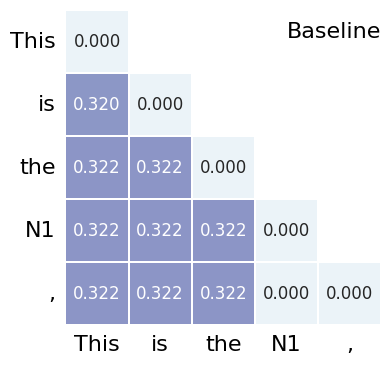

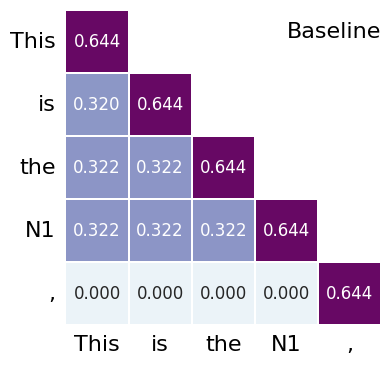

In [29]:
# Baseline
nnc_stimulus_dict = mean_nnc(diaparser_ewt_parse, 'baseline', NNC_REFERENCE)
plot_nnc(nnc_stimulus_dict['first'], 'baseline', './figures/nnc/nnc_electra_ewt_first_baseline.pdf')
plot_nnc(nnc_stimulus_dict['prev'], 'baseline', './figures/nnc/nnc_electra_ewt_prev_baseline.pdf')

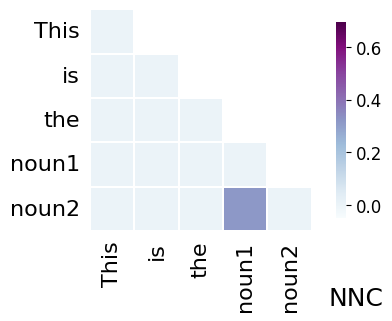

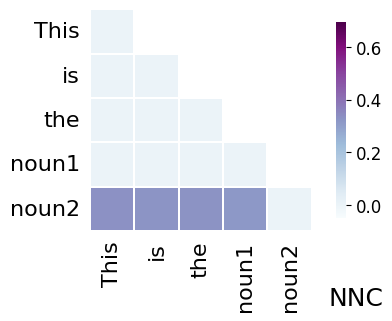

In [30]:
# Difference
nnc_diff_dict = mean_nnc_diff(diaparser_ewt_parse, NNC_REFERENCE)
plot_nnc_diff(nnc_diff_dict['first'], './figures/nnc/nnc_electra_ewt_first_diff.pdf')
plot_nnc_diff(nnc_diff_dict['prev'], './figures/nnc/nnc_electra_ewt_prev_diff.pdf')

## DiaParser (ELECTRA-PTB)

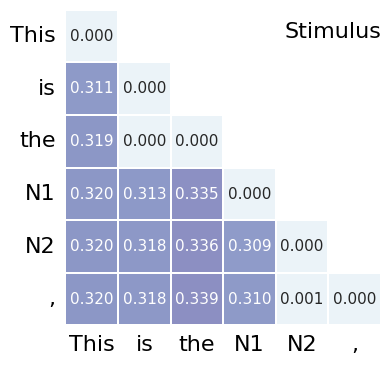

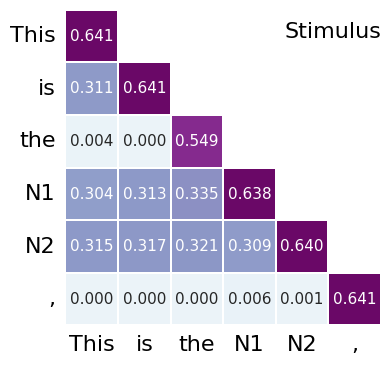

In [31]:
# Stimulus
nnc_stimulus_dict = mean_nnc(diaparser_ptb_parse, 'stimulus', NNC_REFERENCE)
plot_nnc(nnc_stimulus_dict['first'], 'stimulus', './figures/nnc/nnc_electra_ptb_first_stimulus.pdf')
plot_nnc(nnc_stimulus_dict['prev'], 'stimulus', './figures/nnc/nnc_electra_ptb_prev_stimulus.pdf')

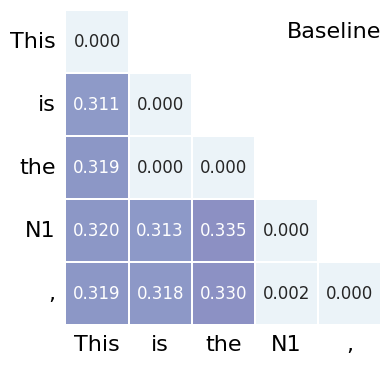

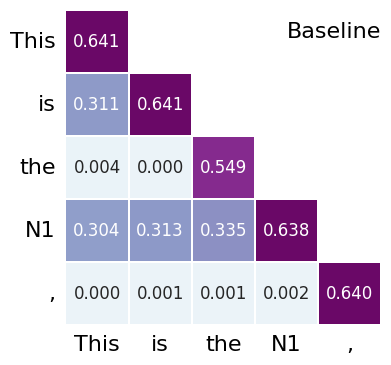

In [32]:
# Baseline
nnc_stimulus_dict = mean_nnc(diaparser_ptb_parse, 'baseline', NNC_REFERENCE)
plot_nnc(nnc_stimulus_dict['first'], 'baseline', './figures/nnc/nnc_electra_ptb_first_baseline.pdf')
plot_nnc(nnc_stimulus_dict['prev'], 'baseline', './figures/nnc/nnc_electra_ptb_prev_baseline.pdf')

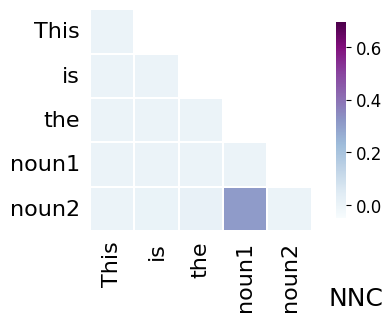

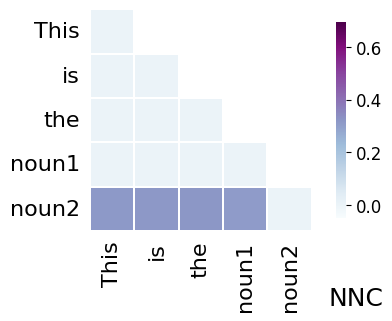

In [33]:
# Difference
nnc_diff_dict = mean_nnc_diff(diaparser_ptb_parse, NNC_REFERENCE)
plot_nnc_diff(nnc_diff_dict['first'], './figures/nnc/nnc_electra_ptb_first_diff.pdf')
plot_nnc_diff(nnc_diff_dict['prev'], './figures/nnc/nnc_electra_ptb_prev_diff.pdf')

## Correlation between distribution changes and edits

In [34]:
threshold = 0.45 * math.log(2)

def corr_arcs(parse):
    '''
    Compute the MCC, AP, and edit ratio wrt. dependency arcs.
    '''
    nps_stimulus_pred, nps_stimulus_div, nps_stimulus_label = [], [], []
    nps_baseline_pred, nps_baseline_div, nps_baseline_label = [], [], []
    mvrr_stimulus_pred, mvrr_stimulus_div, mvrr_stimulus_label = [], [], []
    mvrr_baseline_pred, mvrr_baseline_div, mvrr_baseline_label = [], [], []
    nnc_stimulus_pred, nnc_stimulus_div, nnc_stimulus_label = [], [], []
    nnc_baseline_pred, nnc_baseline_div, nnc_baseline_label = [], [], []
    
    nps_stimulus_edit = []
    nps_baseline_edit = []
    mvrr_stimulus_edit = []
    mvrr_baseline_edit = []
    nnc_stimulus_edit = []
    nnc_baseline_edit = []

    for field in parse:
        field.compute_charts()
        stimulus_parse = field.parses['stimulus']
        baseline_parse = field.parses['baseline']
        
        stimulus_arc = stimulus_parse['arc_preds']
        baseline_arc = baseline_parse['arc_preds']
        
        len_stimulus = stimulus_arc.shape[0]
        len_baseline = baseline_arc.shape[0]
    
        div_stimulus = field.get_chart('stimulus', 'div_prev').numpy()
        div_baseline = field.get_chart('baseline', 'div_prev').numpy()

        # Stimulus
        stimulus_edits = np.zeros((len_stimulus, len_stimulus), dtype=np.int8)
        for length in range(1, len_stimulus+1):
            if length == 1:
                stimulus_edits[length-1][0] = 0
            else:
                stimulus_edits[length-1] = stimulus_arc[length-1] != stimulus_arc[length-2]

        # Ignore the diagonals as there no edits that can be compared to.
        div_stimulus = np.concatenate([div_stimulus[idx][:idx] for idx in range(1, len_stimulus)])
        pred_stimulus = (div_stimulus > threshold).astype(np.int8)
        stimulus_edits = np.concatenate([stimulus_edits[idx][:idx] for idx in range(1, len_stimulus)])

        # Baseline
        baseline_edits = np.zeros((len_baseline, len_baseline), dtype=np.int8)
        for length in range(1, len_baseline+1):
            if length == 1:
                baseline_edits[length-1][0] = 0
            else:
                baseline_edits[length-1] = baseline_arc[length-1] != baseline_arc[length-2]

        # Ignore the diagonals as there no edits that can be compared to.
        div_baseline = np.concatenate([div_baseline[idx][:idx] for idx in range(1, len_baseline)])
        pred_baseline = (div_baseline > threshold).astype(np.int8)
        baseline_edits = np.concatenate([baseline_edits[idx][:idx] for idx in range(1, len_baseline)])

        # Append according to source
        if field.source == 'nnc':
            nnc_stimulus_pred.extend(pred_stimulus.tolist())
            nnc_stimulus_div.extend(div_stimulus.tolist())
            nnc_stimulus_label.extend(stimulus_edits.tolist())
            nnc_baseline_pred.extend(pred_baseline.tolist())
            nnc_baseline_div.extend(div_baseline.tolist())
            nnc_baseline_label.extend(baseline_edits.tolist())
            nnc_stimulus_edit.append(np.mean(stimulus_edits))
            nnc_baseline_edit.append(np.mean(baseline_edits))
        elif field.source == 'classic-nps':
            nps_stimulus_pred.extend(pred_stimulus.tolist())
            nps_stimulus_div.extend(div_stimulus.tolist())
            nps_stimulus_label.extend(stimulus_edits.tolist())
            nps_baseline_pred.extend(pred_baseline.tolist())
            nps_baseline_div.extend(div_baseline.tolist())
            nps_baseline_label.extend(baseline_edits.tolist())
            nps_stimulus_edit.append(np.mean(stimulus_edits))
            nps_baseline_edit.append(np.mean(baseline_edits))
        elif field.source == 'classic-mvrr':
            mvrr_stimulus_pred.extend(pred_stimulus.tolist())
            mvrr_stimulus_div.extend(div_stimulus.tolist())
            mvrr_stimulus_label.extend(stimulus_edits.tolist())
            mvrr_baseline_pred.extend(pred_baseline.tolist())
            mvrr_baseline_div.extend(div_baseline.tolist())
            mvrr_baseline_label.extend(baseline_edits.tolist())
            mvrr_stimulus_edit.append(np.mean(stimulus_edits))
            mvrr_baseline_edit.append(np.mean(baseline_edits))

    print('MCC of NNC stimulus: ', metrics.matthews_corrcoef(nnc_stimulus_label, nnc_stimulus_pred))
    print('MCC of NNC baseline: ', metrics.matthews_corrcoef(nnc_baseline_label, nnc_baseline_pred))
    print('AP of NNC stimulus: ', metrics.average_precision_score(nnc_stimulus_label, nnc_stimulus_div, average='macro'))
    print('AP of NNC baseline: ', metrics.average_precision_score(nnc_baseline_label, nnc_baseline_div, average='macro'))
    print('NNC stimulus edit: ', statistics.mean(nnc_stimulus_edit))
    print('NNC baseline edit: ', statistics.mean(nnc_baseline_edit))
    print('\n')
    
    print('MCC of NPS stimulus: ', metrics.matthews_corrcoef(nps_stimulus_label, nps_stimulus_pred))
    print('MCC of NPS baseline: ', metrics.matthews_corrcoef(nps_baseline_label, nps_baseline_pred))
    print('AP of NPS stimulus: ', metrics.average_precision_score(nps_stimulus_label, nps_stimulus_div, average='macro'))
    print('AP of NPS baseline: ', metrics.average_precision_score(nps_baseline_label, nps_baseline_div, average='macro'))
    print('NPS stimulus edit: ', statistics.mean(nps_stimulus_edit))
    print('NPS baseline edit: ', statistics.mean(nps_baseline_edit))
    print('\n')
    
    print('MCC of MVRR stimulus: ', metrics.matthews_corrcoef(mvrr_stimulus_label, mvrr_stimulus_pred))
    print('MCC of MVRR baseline: ', metrics.matthews_corrcoef(mvrr_baseline_label, mvrr_baseline_pred))
    print('AP of MVRR stimulus: ', metrics.average_precision_score(mvrr_stimulus_label, mvrr_stimulus_div, average='macro'))
    print('AP of MVRR baseline: ', metrics.average_precision_score(mvrr_baseline_label, mvrr_baseline_div, average='macro'))
    print('MVRR stimulus edit: ', statistics.mean(mvrr_stimulus_edit))
    print('MVRR baseline edit: ', statistics.mean(mvrr_baseline_edit))

def corr_labels(parse, index2label):
    '''
    Compute the MCC, AP, and edit ratio wrt. dependency labels.
    '''
    label_dict = {value: idx for idx, value in enumerate(index2label)}
    nps_stimulus_pred, nps_stimulus_div, nps_stimulus_label = [], [], []
    nps_baseline_pred, nps_baseline_div, nps_baseline_label = [], [], []
    mvrr_stimulus_pred, mvrr_stimulus_div, mvrr_stimulus_label = [], [], []
    mvrr_baseline_pred, mvrr_baseline_div, mvrr_baseline_label = [], [], []
    nnc_stimulus_pred, nnc_stimulus_div, nnc_stimulus_label = [], [], []
    nnc_baseline_pred, nnc_baseline_div, nnc_baseline_label = [], [], []
    
    nps_stimulus_edit = []
    nps_baseline_edit = []
    mvrr_stimulus_edit = []
    mvrr_baseline_edit = []
    nnc_stimulus_edit = []
    nnc_baseline_edit = []

    for field in parse:
        field.compute_charts()
        stimulus_parse = field.parses['stimulus']
        baseline_parse = field.parses['baseline']
        
        stimulus_rel = stimulus_parse['rel_preds']
        baseline_rel = baseline_parse['rel_preds']
        
        len_stimulus = len(stimulus_rel[-1])
        len_baseline = len(baseline_rel[-1])
    
        div_stimulus = field.get_chart('stimulus', 'div_prev').numpy()
        div_baseline = field.get_chart('baseline', 'div_prev').numpy()

        # Convert stimulus_rel and baseline_rel to index to ease computation
        stimulus_rel_tensor = np.empty((len_stimulus, len_stimulus))
        stimulus_rel_tensor.fill(np.inf)
        for row_idx, row in enumerate(stimulus_rel):
            stimulus_rel_tensor[row_idx][:row_idx+1] = np.array([label_dict[label] for label in row], dtype=np.int8)
    
        baseline_rel_tensor = np.empty((len_baseline, len_baseline))
        baseline_rel_tensor.fill(np.inf)
    
        for row_idx, row in enumerate(baseline_rel):
            baseline_rel_tensor[row_idx][:row_idx+1] = np.array([label_dict[label] for label in row], dtype=np.int8)

        # Stimulus
        stimulus_edits = np.zeros((len_stimulus, len_stimulus))
        for length in range(1, len_stimulus+1):
            if length == 1:
                stimulus_edits[length-1][0] = 0
            else:
                stimulus_edits[length-1] = stimulus_rel_tensor[length-1] != stimulus_rel_tensor[length-2]

        div_stimulus = np.concatenate([div_stimulus[idx][:idx] for idx in range(1, len_stimulus)])
        pred_stimulus = (div_stimulus > threshold).astype(np.int8)
        stimulus_edits = np.concatenate([stimulus_edits[idx][:idx] for idx in range(1, len_stimulus)])

        # Baseline
        baseline_edits = np.zeros((len_baseline, len_baseline), dtype=np.int8)
        for length in range(1, len_baseline+1):
            if length == 1:
                baseline_edits[length-1][0] = 0
            else:
                baseline_edits[length-1] = baseline_rel_tensor[length-1] != baseline_rel_tensor[length-2]

        div_baseline = np.concatenate([div_baseline[idx][:idx] for idx in range(1, len_baseline)])
        pred_baseline = (div_baseline > threshold).astype(np.int8)
        baseline_edits = np.concatenate([baseline_edits[idx][:idx] for idx in range(1, len_baseline)])

        # Append according to source
        if field.source == 'nnc':
            nnc_stimulus_pred.extend(pred_stimulus.tolist())
            nnc_stimulus_div.extend(div_stimulus.tolist())
            nnc_stimulus_label.extend(stimulus_edits.tolist())
            nnc_baseline_pred.extend(pred_baseline.tolist())
            nnc_baseline_div.extend(div_baseline.tolist())
            nnc_baseline_label.extend(baseline_edits.tolist())
            nnc_stimulus_edit.append(np.mean(stimulus_edits))
            nnc_baseline_edit.append(np.mean(baseline_edits))
        elif field.source == 'classic-nps':
            nps_stimulus_pred.extend(pred_stimulus.tolist())
            nps_stimulus_div.extend(div_stimulus.tolist())
            nps_stimulus_label.extend(stimulus_edits.tolist())
            nps_baseline_pred.extend(pred_baseline.tolist())
            nps_baseline_div.extend(div_baseline.tolist())
            nps_baseline_label.extend(baseline_edits.tolist())
            nps_stimulus_edit.append(np.mean(stimulus_edits))
            nps_baseline_edit.append(np.mean(baseline_edits))
        elif field.source == 'classic-mvrr':
            mvrr_stimulus_pred.extend(pred_stimulus.tolist())
            mvrr_stimulus_div.extend(div_stimulus.tolist())
            mvrr_stimulus_label.extend(stimulus_edits.tolist())
            mvrr_baseline_pred.extend(pred_baseline.tolist())
            mvrr_baseline_div.extend(div_baseline.tolist())
            mvrr_baseline_label.extend(baseline_edits.tolist())
            mvrr_stimulus_edit.append(np.mean(stimulus_edits))
            mvrr_baseline_edit.append(np.mean(baseline_edits))

    print('MCC of NNC stimulus: ', metrics.matthews_corrcoef(nnc_stimulus_label, nnc_stimulus_pred))
    print('MCC of NNC baseline: ', metrics.matthews_corrcoef(nnc_baseline_label, nnc_baseline_pred))
    print('AP of NNC stimulus: ', metrics.average_precision_score(nnc_stimulus_label, nnc_stimulus_div, average='macro'))
    print('AP of NNC baseline: ', metrics.average_precision_score(nnc_baseline_label, nnc_baseline_div, average='macro'))
    print('NNC stimulus edit: ', statistics.mean(nnc_stimulus_edit))
    print('NNC baseline edit: ', statistics.mean(nnc_baseline_edit))
    print('\n')
    
    print('MCC of NPS stimulus: ', metrics.matthews_corrcoef(nps_stimulus_label, nps_stimulus_pred))
    print('MCC of NPS baseline: ', metrics.matthews_corrcoef(nps_baseline_label, nps_baseline_pred))
    print('AP of NPS stimulus: ', metrics.average_precision_score(nps_stimulus_label, nps_stimulus_div, average='macro'))
    print('AP of NPS baseline: ', metrics.average_precision_score(nps_baseline_label, nps_baseline_div, average='macro'))
    print('NPS stimulus edit: ', statistics.mean(nps_stimulus_edit))
    print('NPS baseline edit: ', statistics.mean(nps_baseline_edit))
    print('\n')
    
    print('MCC of MVRR stimulus: ', metrics.matthews_corrcoef(mvrr_stimulus_label, mvrr_stimulus_pred))
    print('MCC of MVRR baseline: ', metrics.matthews_corrcoef(mvrr_baseline_label, mvrr_baseline_pred))
    print('AP of MVRR stimulus: ', metrics.average_precision_score(mvrr_stimulus_label, mvrr_stimulus_div, average='macro'))
    print('AP of MVRR baseline: ', metrics.average_precision_score(mvrr_baseline_label, mvrr_baseline_div, average='macro'))
    print('MVRR stimulus edit: ', statistics.mean(mvrr_stimulus_edit))
    print('MVRR baseline edit: ', statistics.mean(mvrr_baseline_edit))

## Dependency Arcs

In [35]:
# Biaffine parser (RoBERTa)
corr_arcs(biaffine_parse)

MCC of NNC stimulus:  0.9905214456214955
MCC of NNC baseline:  0.96367567215592
AP of NNC stimulus:  0.9999999999999999
AP of NNC baseline:  0.9958699448970012
NNC stimulus edit:  0.53214709371293
NNC baseline edit:  0.4128113879003559


MCC of NPS stimulus:  0.9537940805650953
MCC of NPS baseline:  0.9182510129901557
AP of NPS stimulus:  0.9173598011574999
AP of NPS baseline:  0.8826221156548582
NPS stimulus edit:  0.10971701909201909
NPS baseline edit:  0.11334370286576169


MCC of MVRR stimulus:  0.8593300975815771
MCC of MVRR baseline:  0.9267928633825688
AP of MVRR stimulus:  0.8751080395485715
AP of MVRR baseline:  0.894874722992414
MVRR stimulus edit:  0.12496912809412809
MVRR baseline edit:  0.10327500658383011


In [36]:
# DiaParser (ELECTRA-EWT)
corr_arcs(diaparser_ewt_parse)

MCC of NNC stimulus:  0.9718354840565687
MCC of NNC baseline:  1.0
AP of NNC stimulus:  0.9999100921777364
AP of NNC baseline:  1.0
NNC stimulus edit:  0.6669039145907473
NNC baseline edit:  0.6


MCC of NPS stimulus:  0.9455100271363526
MCC of NPS baseline:  0.9171016812236302
AP of NPS stimulus:  0.977816221902533
AP of NPS baseline:  0.9647782706033068
NPS stimulus edit:  0.12733481795981796
NPS baseline edit:  0.12714864792070674


MCC of MVRR stimulus:  0.797893430748369
MCC of MVRR baseline:  0.944844087793252
AP of MVRR stimulus:  0.9067032611591297
AP of MVRR baseline:  0.9742808397003704
MVRR stimulus edit:  0.14781052281052282
MVRR baseline edit:  0.10707881443175561


In [37]:
# DiaParser (ELECTRA-PTB)
corr_arcs(diaparser_ptb_parse)

MCC of NNC stimulus:  0.8063270485374868
MCC of NNC baseline:  0.7840488783548559
AP of NNC stimulus:  0.9984589015649586
AP of NNC baseline:  0.9924194140292905
NNC stimulus edit:  0.5309608540925267
NNC baseline edit:  0.402135231316726


MCC of NPS stimulus:  0.9097178401499235
MCC of NPS baseline:  0.9221135507721542
AP of NPS stimulus:  0.9670460375359694
AP of NPS baseline:  0.9751516219462689
NPS stimulus edit:  0.1051497113997114
NPS baseline edit:  0.12256877109818286


MCC of MVRR stimulus:  0.7968238744265379
MCC of MVRR baseline:  0.9601348155480764
AP of MVRR stimulus:  0.9205914166436522
AP of MVRR baseline:  0.9900094465255201
MVRR stimulus edit:  0.12468087468087469
MVRR baseline edit:  0.0927550934903876


## Dependency Labels

In [38]:
# Biaffine parser (RoBERTa)
from supar import Parser
parser = Parser.load('dep-biaffine-roberta-en')
index2label_biaffine = parser.REL.vocab

corr_labels(biaffine_parse, index2label_biaffine)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MCC of NNC stimulus:  0.5514894008888539
MCC of NNC baseline:  0.774493186778
AP of NNC stimulus:  0.4071091356355321
AP of NNC baseline:  0.8987857088445841
NNC stimulus edit:  0.26666666666666666
NNC baseline edit:  0.3074733096085409


MCC of NPS stimulus:  0.8588024589123701
MCC of NPS baseline:  0.7734633453261871
AP of NPS stimulus:  0.9208274263762266
AP of NPS baseline:  0.777255201877536
NPS stimulus edit:  0.08896450771450772
NPS baseline edit:  0.08058989621489622


MCC of MVRR stimulus:  0.7080310137939617
MCC of MVRR baseline:  0.8426944549794231
AP of MVRR stimulus:  0.795510506518771
AP of MVRR baseline:  0.8547223603662463
MVRR stimulus edit:  0.09377879065379065
MVRR baseline edit:  0.09023423471952884


In [39]:
# DiaParser(ELECTRA-EWT)
from diaparser.parsers import Parser
parser = Parser.load('en_ewt.electra-base')
index2label_diaparser_ewt = parser.REL.vocab

corr_labels(diaparser_ewt_parse, index2label_diaparser_ewt)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


MCC of NNC stimulus:  0.3737015582855602
MCC of NNC baseline:  0.5345224838248488
AP of NNC stimulus:  0.3003140977305627
AP of NNC baseline:  0.47771083053134455
NNC stimulus edit:  0.2690391459074733
NNC baseline edit:  0.3


MCC of NPS stimulus:  0.7808017669444536
MCC of NPS baseline:  0.6981153081022023
AP of NPS stimulus:  0.8550110588302946
AP of NPS baseline:  0.7645768677562426
NPS stimulus edit:  0.09691801254301255
NPS baseline edit:  0.07876557674351792


MCC of MVRR stimulus:  0.6125340381462051
MCC of MVRR baseline:  0.7488002268099065
AP of MVRR stimulus:  0.7546913905405335
AP of MVRR baseline:  0.8665439981485019
MVRR stimulus edit:  0.10877698690198691
MVRR baseline edit:  0.07741873458785224


In [40]:
# DiaParser (ELECTRA-PTB)
from diaparser.parsers import Parser
parser = Parser.load('en_ptb.electra-base')
index2label_diaparser_ptb = parser.REL.vocab

corr_labels(diaparser_ptb_parse, index2label_diaparser_ptb)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


MCC of NNC stimulus:  0.2292292072094794
MCC of NNC baseline:  0.5241060997149382
AP of NNC stimulus:  0.554198439667756
AP of NNC baseline:  0.7963922164891041
NNC stimulus edit:  0.269276393831554
NNC baseline edit:  0.302135231316726


MCC of NPS stimulus:  0.7841127309026533
MCC of NPS baseline:  0.7156154882509449
AP of NPS stimulus:  0.8914044255232637
AP of NPS baseline:  0.7366007902728323
NPS stimulus edit:  0.09084942834942836
NPS baseline edit:  0.08426053113553114


MCC of MVRR stimulus:  0.6438755438646357
MCC of MVRR baseline:  0.8570149323559014
AP of MVRR stimulus:  0.784779136419726
AP of MVRR baseline:  0.908157315922933
MVRR stimulus edit:  0.09738594738594739
MVRR baseline edit:  0.07820093849505615
